In [4]:
import os
import cv2
import glob
import matplotlib.pyplot as plt
from skimage import io
import rioxarray as rxr
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
from PIL import Image 
from constants import labels

from constants import labels
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import copy
import time
from collections import defaultdict

import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
import torch.nn.functional as F

In [121]:
class OpenSendaiBenchDataset(Dataset):
    """
    An implementation of a PyTorch dataset for loading pairs of observable variables and ground truth labels.
    Inspired by https://pytorch.org/tutorials/beginner/data_loading_tutorial.html.
    """
    def __init__(self, obsvariables_path: str, groundtruth_path: str, country: str, signals: list, transform: transforms = None):
        """
        Constructs an OpenSendaiBenchDataset.
        :param obsvariables_path: Path to the source folder of observable variables
        :param groundtruth_path: Path to the source folder of corresponding ground truth labels
        :param transform: Callable transformation to apply to images upon loading
        """
        self.obsvariables_path = obsvariables_path
        self.groundtruth_path = groundtruth_path
        self.country = country
        self.signals = signals
        self.transform = transform

    def __len__(self):
        """
        Implements the len(SeaIceDataset) magic method. Required to implement by Dataset superclass.
        When training/testing, this method tells our training loop how much longer we have to go in our Dataset.
        :return: Length of OpenSendaiBenchDataset
        """
        return 5 #len(self.groundtruth_files)/labels[self.country]

    def __getitem__(self, i: int):
        """
        Implements the OpenSendaiBenchDataset[i] magic method. Required to implement by Dataset superclass.
        When training/testing, this method is used to actually fetch data.
        :param i: Index of which image pair to fetch
        :return: Dictionary with pairs of observable variables and ground truth labels.
        """

        obsvariable = np.zeros([len(self.signals),372,372])
        for s in range(len(self.signals)):
            for file in glob.glob(str(os.getcwd()+self.obsvariables_path+
                                    '**/'+self.country+'_*/'+self.country+'_'+
                                    str(i)+'_'+'of_*/2019*_'+self.signals[s]+'.tif')):
                a = cv2.imread(file, cv2.IMREAD_UNCHANGED)
                a = a.reshape(1,a.shape[0],a.shape[1])
                obsvariable[s,:,:] = a
                
        groundtruth = np.zeros([len(labels[self.country]),8,8])
        for w in range(len(labels[self.country])): # to make composite. in AFG, we got 5 bldgtypes
            for file in glob.glob(str(os.getcwd()+self.groundtruth_path+
                                      self.country+'*/tiles/images/'+
                                      self.country+'_nbldg_'+labels[self.country][w]+'_'+str(i)+'_'+'of_'+'*.tif')):
                a = cv2.imread(file, cv2.IMREAD_UNCHANGED)
                # a = cv2.resize(a, (372,372), interpolation = cv2.INTER_NEAREST)
                a = a.reshape(1,a.shape[0],a.shape[1])
                groundtruth[w,:,:] = a

        obsvariable = torch.from_numpy(obsvariable).float()
        groundtruth = torch.from_numpy(groundtruth).float()
    
        sample = {"obsvariable": obsvariable, "groundtruth": groundtruth}
        if self.transform:
            sample = {"obsvariable": self.transform(obsvariable),
                      "groundtruth": self.transform(groundtruth).squeeze(0).long()}
        return sample

    def visualise(self, i):
        """
        Allows us to visualise a particular SAR/chart pair.
        :param i: Index of which image pair to visualise
        :return: None
        """
        sample = self[i]
        fig1, axs1 = plt.subplots(1,len(self.signals))
        for s in range(len(self.signals)):
            axs1[s].imshow(sample['obsvariable'][s,:,:])
            axs1[s].set_title(str(self.signals[s]))
            axs1[s].set_xticks([])
            axs1[s].set_yticks([])
        plt.tight_layout()
 
        fig2, axs2 = plt.subplots(1,len(labels[self.country]))
        for w in range(len(labels[self.country])): 
            axs2[w].imshow(sample['groundtruth'][w,:,:])
            axs2[w].set_title(labels[self.country][w])
            axs2[w].set_xticks([])
            axs2[w].set_yticks([])
        plt.tight_layout()

In [104]:
dataset = OpenSendaiBenchDataset(   obsvariables_path="/obsvariables/", 
                                    groundtruth_path="/groundtruth/", 
                                    country='AFG',
                                    # signals = ['blue','green','red'],
                                    signals = ['VH','VV','aerosol','blue','green','red','red1','red2','red3','nir','red4','vapor','swir1','swir2'],
                                    transform=None)
print(dataset[1]['obsvariable'].shape)
print(dataset[1]['groundtruth'].shape)
print(len(dataset))

torch.Size([1, 14, 372, 372])
torch.Size([1, 5, 8, 8])
5


TypeError: Invalid shape (14, 372, 372) for image data

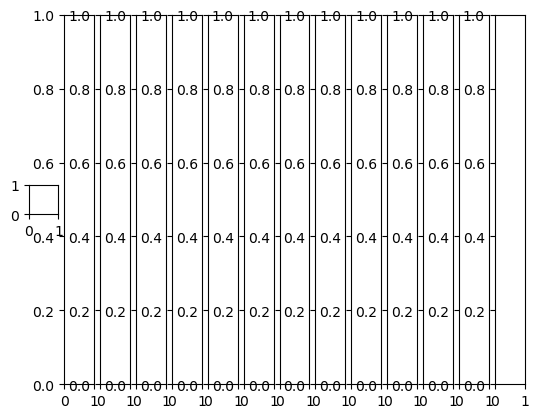

In [105]:
dataset.visualise(1)  # we can visualise an item with our custom function

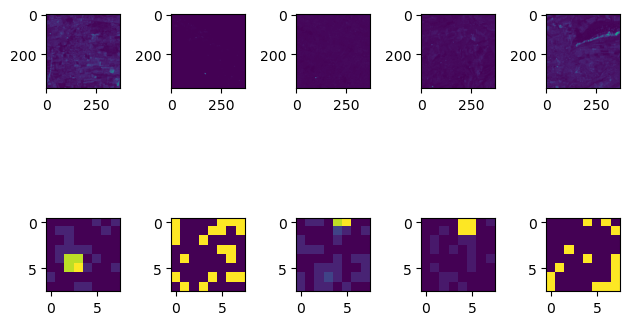

In [ ]:
fig, ax = plt.subplots(2, 5)
for i in range(len(dataset)):
    ax[0,i-1].imshow(dataset[i+1]["obsvariable"][1,:,:]) #c3l
    ax[1,i-1].imshow(dataset[i+1]["groundtruth"][1,:,:]) #c3l
plt.tight_layout()
plt.show()

In [106]:
## Constructing the U-net architecture
# 8x372x372
input = torch.from_numpy(dataset[1]['obsvariable']).float()

## Encoder
# ....
e11 = nn.Conv2d(in_channels=14, out_channels=64, kernel_size=5, padding=1)
xe11 = relu(e11(input))     # outputs 64x370x370
# ....
e12 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=1) 
xe12 = relu(e12(xe11))      # outputs 64x368x368
# ....
pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
xp1 = pool1(xe12)           # outputs 64x184x184
# ....
# ....
e21 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=1)
xe21 = relu(e21(xp1))       # outputs 128x182x182
# ....
e22 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, padding=1) 
xe22 = relu(e22(xe21))      # outputs 128x180x180
# ....
pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
xp2 = pool1(xe22)           # outputs 128x90x90
# ....
# ....
e31 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding=1)
xe31 = relu(e31(xp2))       # outputs 256x88x88
# ....
e32 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=5, padding=1) 
xe32 = relu(e32(xe31))      # outputs 256x86x86
# ....
pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
xp3 = pool1(xe32)           # outputs 256x43x43
# ....
# ....
e41 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=5, padding=1)
xe41 = relu(e41(xp3))       # outputs 512x41x41
# ....
e42 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=5, padding=1) 
xe42 = relu(e42(xe41))      # outputs 512x39x39
# ....
pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
xp4 = pool1(xe42)           # outputs 512x19x19
# ....
# ....
e51 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=5, padding=1) 
xe51 = relu(e51(xp4))      # outputs 1024x17x17
# ....
e52 = nn.Conv2d(in_channels=1024, out_channels=len(labels['AFG']), kernel_size=12, padding=1) 
xe52 = relu(e52(xe51))      # outputs 1024x17x17
print(xe52.mean())

TypeError: expected np.ndarray (got Tensor)

In [107]:
class UNet(nn.Module):
    def __init__(self, n_class:int):
        super().__init__()
        self.e11 = nn.Conv2d(in_channels=14, out_channels=64, kernel_size=5, padding=1)
        self.e12 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=1) 
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e21 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=1)
        self.e22 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, padding=1) 
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e31 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding=1)
        self.e32 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=5, padding=1) 
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.e41 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=5, padding=1)
        self.e42 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=5, padding=1) 
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.e51 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=5, padding=1) 
        self.e52 = nn.Conv2d(in_channels=1024, out_channels=n_class, kernel_size=12, padding=1) 

    def forward(self, x: torch.Tensor):
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))

        return xe52

In [108]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader

class Segmentation(pl.LightningModule):
    """
    A LightningModule designed to perform image segmentation.
    """

    def __init__(self,
                 train_dataloader: DataLoader,
                 val_dataloader: DataLoader,
                 model: nn.Module,
                 criterion: callable,
                 learning_rate: float,
                 metric: callable,
                 ):
        """
        Construct a Segmentation LightningModule.
        Note that we keep hyperparameters separate from dataloaders to prevent data leakage at test time.
        :param train_dataloader: Dataloader with training data, left as None at test time
        :param val_dataloader: Dataloader with validation data, left as None at test time
        :param model: PyTorch model
        :param criterion: PyTorch loss function against which to train model
        :param learning_rate: Float learning rate for our optimiser
        :param metric: PyTorch function for model evaluation
        """
        super().__init__()
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate
        self.metric = metric

    def training_step(self, batch: dict, batch_idx: int):
        """
        Perform a pass through a batch of training data.
        :param batch: Batch of image pairs
        :param batch_idx: Index of batch
        :return: Loss from this batch of data for use in backprop
        """
        x, y  = batch["obsvariable"], batch["groundtruth"]
        y_hat = self.model(x)
        loss = torch.sqrt(self.criterion(y_hat, y)+1e-6)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y  = batch["obsvariable"], batch["groundtruth"]
        y_hat = self.model(x)
        loss = torch.sqrt(self.criterion(y_hat, y)+1e-6)
        metric = self.metric(y_hat, y)
        self.log("val_loss", loss)
        self.log("val_metric", metric)
        return loss

    def testing_step(self, batch, batch_idx):
        x, y  = batch["sar"], batch["chart"]
        y_hat = self.model(x)
        loss = torch.sqrt(self.criterion(y_hat, y)+1e-6)
        metric = self.metric(y_hat, y)
        self.log("test_loss", loss)
        self.log("test_metric", metric)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return {
            "optimizer": optimizer
        }

In [109]:
torch.manual_seed(0)
model = UNet(n_class=len(labels['AFG']))
print(model)  # shows us a convenient summary of our model

UNet(
  (e11): Conv2d(14, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (e12): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (e22): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (e32): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e41): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (e42): Conv2d(512, 512, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e51): Conv2d(512, 1024, kernel_size=

In [111]:
# tensor_obsvariable = torch.from_numpy(dataset[1]["obsvariable"]).float()
# tensor_obsvariable.shape
# tensor_obsvariable_batch = tensor_obsvariable.unsqueeze(0)
# tensor_obsvariable_batch.shape

In [112]:
output = model(tensor_obsvariable_batch)
output.shape

torch.Size([1, 5, 8, 8])

In [113]:
output[0, :, 4, 4]

tensor([0.0000, 0.7813, 0.3074, 0.0000, 0.7299], grad_fn=<SelectBackward0>)

In [114]:
map = output[0].argmax(0)
map

tensor([[1, 2, 2, 2, 2, 2, 2, 2],
        [1, 4, 4, 4, 4, 4, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 4, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 4, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [4, 4, 4, 4, 4, 4, 4, 2]])

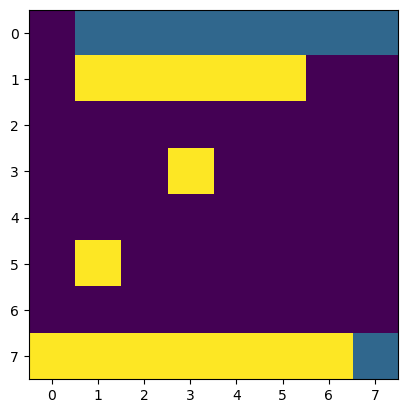

In [115]:
plt.imshow(map.numpy()) # convert torch tensor to numpy array before passing into matplotlib
plt.show()

In [122]:
train_dataset = OpenSendaiBenchDataset( obsvariables_path="/obsvariables/", 
                                        groundtruth_path="/groundtruth/", 
                                        country='AFG', 
                                        signals = ['VH','VV','aerosol','blue','green','red','red1','red2','red3','nir','red4','vapor','swir1','swir2'])
train_dataloader = DataLoader(train_dataset, shuffle=True)

val_dataset = OpenSendaiBenchDataset(   obsvariables_path="/obsvariables/", 
                                        groundtruth_path="/groundtruth/", 
                                        country='AFG', 
                                        signals = ['VH','VV','aerosol','blue','green','red','red1','red2','red3','nir','red4','vapor','swir1','swir2'])
val_dataloader = DataLoader(val_dataset, shuffle=True)


In [123]:
criterion = nn.MSELoss()
learning_rate = 1e-4
metric = nn.MSELoss()
segmenter = Segmentation(train_dataloader, val_dataloader, 
                         model, criterion, learning_rate, metric)

In [118]:
import wandb
wandb.init(project="opensendaibench")  # initialise wandb
wandb_logger = pl.loggers.WandbLogger(project="opensendaibench")  # create a logger object
wandb_logger.watch(model, log="all", log_freq=10)  # tell our logger to watch the model we are training to track parameters and gradients
wandb_logger.experiment.config.update(  # log experimental config items of interest
    {
        "learning_rate": learning_rate
    }
)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


/Users/joshuadimasaka/miniconda3/envs/opensendaibench/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [124]:
from pytorch_lightning.callbacks import ModelCheckpoint
trainer = pl.Trainer(max_epochs=100)  # also consider constructing with pl.Trainer.from_argparse_args(args)
trainer.logger = wandb_logger  # set trainer to use the logger we've created
trainer.callbacks.append(ModelCheckpoint(monitor="val_loss"))  # tell our trainer to save the best-performing model according to validation loss as we go

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [125]:
trainer.fit(segmenter, train_dataloader, val_dataloader)


  | Name      | Type    | Params
--------------------------------------
0 | model     | UNet    | 26.9 M
1 | criterion | MSELoss | 0     
2 | metric    | MSELoss | 0     
--------------------------------------
26.9 M    Trainable params
0         Non-trainable params
26.9 M    Total params
107.499   Total estimated model params size (MB)


/Users/joshuadimasaka/miniconda3/envs/opensendaibench/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/joshuadimasaka/miniconda3/envs/opensendaibench/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 999: 100%|██████████| 5/5 [00:00<00:00,  6.78it/s, v_num=uk6i]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 5/5 [00:01<00:00,  4.98it/s, v_num=uk6i]


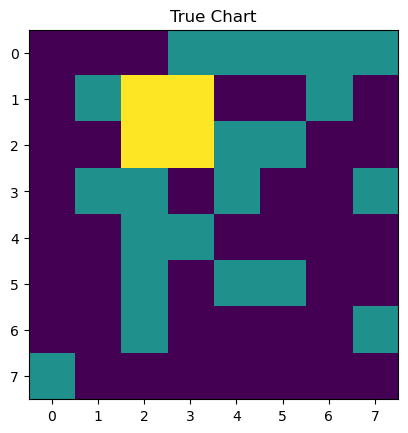

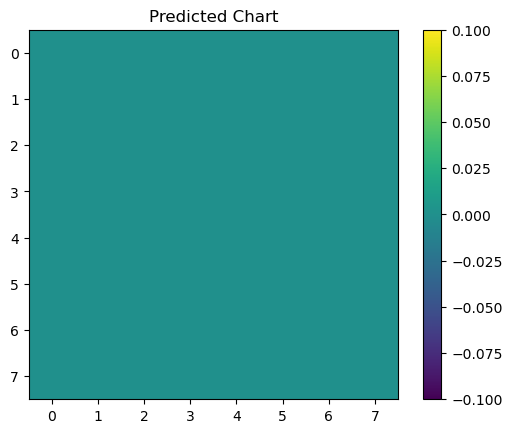

In [159]:
batch = next(iter(val_dataloader))
output = model(batch["obsvariable"])
output.shape
map = output[0,4,:,:]
plt.imshow(batch["groundtruth"][0,4,:,:])
plt.title("True Chart")
plt.show()
img = plt.imshow(map.detach().numpy()) # convert torch tensor to numpy array before passing into matplotlib
plt.colorbar(img)
plt.title("Predicted Chart")
plt.show()